In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from constants import TRAINING_DATA_DIR
from PIL import Image
import cv2
from data_handling.track_dataset import TrackDataset

D:\task3_duetsch_sodamin\venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
dataset = TrackDataset(TRAINING_DATA_DIR, disable_preprocessing=True, dataset_limit=100)

In [3]:
def get_transformed_images(number_of_images):
    random.seed(a=44)
    images = []
    for i in range(number_of_images):
        # index = list(range(0, 9000, 250))[i] # 300,
        image_tensor = dataset[i][0].cpu()
        steering_angle_tensor = dataset[i][1].cpu()

        image_array = ((image_tensor.permute((1, 2, 0)).cpu().numpy() + 1) * 127.5).astype(np.uint8)
        # image_array = image_tensor.cpu().numpy().astype(np.uint8)
        # image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image_array)
        # images.append(image)
        transformed_images = transform(image_array)
        for img in transformed_images:
            images.append(img)
        # image_tensor, steering_angle = TrackDataElement.augment(image_tensor, steering_angle_tensor)
        # images.append(Image.fromarray(((image_tensor.permute((1, 2, 0)).cpu().numpy()  + 1) * 127.5).astype(np.uint8)))

    return images

In [11]:
def transform(image):
    image_height = image.shape[0]
    image_width = image.shape[1]
    image_center = 0.5
    lower_horizontal_threshold = 0.2
    upper_horizontal_threshold = 0.8

    top_vertical_threshold = 0.35
    bottom_vertical_threshold = 0.9
    image[: int(top_vertical_threshold * image_height), ...] //= 4
    image[int(bottom_vertical_threshold * image_height):, ...] //= 4    

    image[..., : int(lower_horizontal_threshold * image_width), :] //= 4
    image[..., int(upper_horizontal_threshold * image_width):, : ] //= 4

    # image[int(lower_vertical_threshold * image_height) : int(upper_vertical_threshold * image_height), int(lower_horizontal_threshold * image_width) : int(upper_horizontal_threshold * image_width)] = 1
    
    return image, image

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)
    result = np.zeros(gray.shape, dtype=np.uint8)
    result = np.logical_or(result, sobel_mag)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    COLOR_MIN = np.array([20, 100, 100], np.uint8)
    COLOR_MAX = np.array([200, 255, 255], np.uint8)
    hsv_yellow_mask = cv2.inRange(hsv_image, COLOR_MIN, COLOR_MAX)
    result = np.logical_or(result, hsv_yellow_mask)

    eq_global = cv2.equalizeHist(gray)
    _, th = cv2.threshold(eq_global, thresh=220, maxval=255, type=cv2.THRESH_BINARY)

    result = np.logical_or(result, th).astype(np.uint8)
    closed_result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, np.ones((5,5), dtype=np.uint8))


    src = np.float32([[360, 135],    # br
                      [0, 135],    # bl
                      [40, 95],   # tl
                      [320, 95]])  # tr
    dst = np.float32([[360, 360],       # br
                      [0, 360],       # bl
                      [0, 0],       # tl
                      [360, 0]])      # tr

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(closed_result, M, (360, 360), flags=cv2.INTER_LINEAR)

    return closed_result, warped

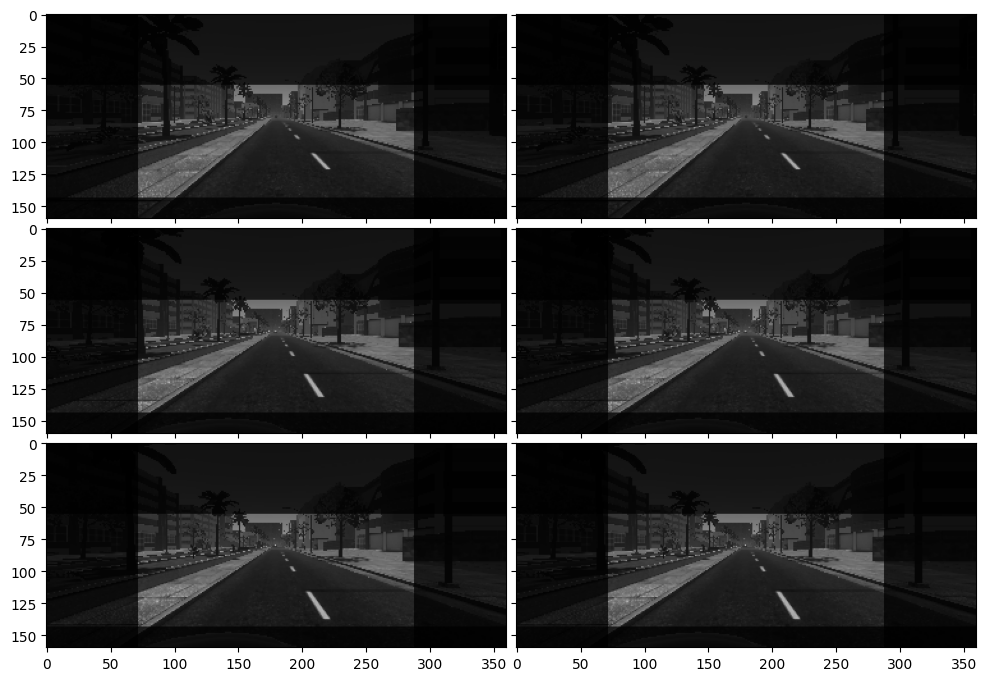

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Note: Comment out the extract_road step in the dataloader before using this notebook
number_of_images = 3
images = get_transformed_images(number_of_images)
number_of_ret_vals = len(images) // number_of_images

fig = plt.figure(figsize=(4 * number_of_images, 4 * number_of_images))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(number_of_images, number_of_ret_vals),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [8]:
# def transform(image):
#     thresh = 0.4
#     image = cv2.GaussianBlur(image, (5, 5), 0)
#     gray_scale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     gray_scale[gray_scale <= 100] = 100
#     image = image.astype(np.int32)
#     mask = (abs(image[..., 0] - image[..., 1]) + abs(image[..., 0] - image[..., 2]) + abs(
#         image[..., 1] - image[..., 2])) <= (thresh * gray_scale)
#     image[~mask] = 0
#     image = image.astype(np.uint8)
#     return image, mask

In [7]:
 # def transform(image):
#    COLOR_MIN = np.array([20, 50, 50], np.uint8)
#    COLOR_MAX = np.array([35, 255, 255], np.uint8)
#    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#    color_region = cv2.inRange(hsv_img, COLOR_MIN, COLOR_MAX)
#
#    return image, color_region

In [8]:
# def transform(image):
#     image = image[120:256, :]
#     IMAGE_H = 256
#     IMAGE_W = 256
#
#     src = np.float32([[0, IMAGE_H], [256, IMAGE_H], [0, 0], [IMAGE_W, 0]])
#     dst = np.float32([[100, IMAGE_H], [156, IMAGE_H], [0, 0], [IMAGE_W, 0]])
#     M = cv2.getPerspectiveTransform(src, dst)  # The transformation matrix
#     Minv = cv2.getPerspectiveTransform(dst, src)  # Inverse transformation
#
#     warped_img = cv2.warpPerspective(image, M, (IMAGE_W, IMAGE_H))  # Image warping
#
#     return warped_img, warped_img


In [9]:
# def transform(image):
#     # image = cv2.GaussianBlur(org_image, (25, 25), 0)
#     image = cv2.GaussianBlur(image, (11, 11), 0)
#     gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     roi = gray_image[50:75, 50:270]
#
#     lower_bound = np.percentile(roi.flatten(), 10)
#     upper_bound = np.percentile(roi.flatten(), 90)
#
#     # (minVal, maxVal, _, _) = cv2.minMaxLoc(roi)
#     mask = cv2.inRange(gray_image, lower_bound, upper_bound)
#     result = cv2.bitwise_and(gray_image, gray_image, mask=mask)
#     result[result > 0] = 255
#     # result[result ] = 0
#     # result = cv2.GaussianBlur(result, (25, 25), 0)
#
#     return roi, result

In [10]:
# def transform(image):
#     canny_low_threshold = 100
#     gray_scale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     canny = cv2.Canny(gray_scale, canny_low_threshold, canny_low_threshold * 3)
#     lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, np.array([]), 20, 15)
#     lines = [] if lines is None else lines
#     # result = image
#     result = np.zeros(image.shape).astype(np.uint8)
#     for x in range(0, len(lines)):
#         for x1, y1, x2, y2 in lines[x]:
#             if y1 < 150 and y2 < 150:
#                 continue
#
#             slope = abs((y2 - y1) / (x2 - x1)) if x2 - x1 != 0 else 1000
#             if 0.5 < slope:
#                 #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
#                 pts = np.array([[x1, y1], [x2, y2]], np.int32)
#                 cv2.polylines(result, [pts], True, (0, 255, 0), 2)
#     normalizedImg = np.zeros(image.shape).astype(np.uint8)
#     image = cv2.normalize(image,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
#     return image, canny, result